# Only Fine Structure (Movre Pischler) Reorganized

## Setup

In [26]:
import numpy as np
import sympy as sp
sp.init_printing(use_latex=True)
from sympy.physics.quantum import Bra, Ket, qapply, Dagger as Dag
from sympy.physics.quantum.cg import CG
np.set_printoptions(precision=3,suppress=True,linewidth=100000, edgeitems=10000)
from sympy.physics.wigner import wigner_9j
from sympy.physics.secondquant import KroneckerDelta
import math
import time
import scipy.linalg
import IPython.display
from IPython.display import Latex
import matplotlib.pyplot as plt
import MarksConstants as mc
import Miscellaneous as misc

from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
from IPython.display import Latex

import matplotlib as mpl
import matplotlib.style
matplotlib.style.use('default')
%matplotlib inline
from copy import copy
from importlib import reload

import MoleculeCalculation as mol

In [27]:
reload(mol)

<module 'MoleculeCalculation' from 'C:\\Users\\Mark O. Brown\\Code\\Molecules_Code_New\\MoleculeCalculation.py'>

# Calculation

In [28]:
lsiBasis, jiBasis, fBasis, lsiBasis2Atom, jiBasis2Atom, fBasis2Atom = mol.createAtomicBases([0,1], [1/2], [0])

In [29]:
E_HFS_5S12_F1F2 = (mc.Rb87_Ground_ToF2-mc.Rb87_Ground_ToF1)/2
E_HFS_5P12_F1F2 = (mc.Rb87_5P12_ToF2-mc.Rb87_5P12_ToF1)/2
E_FS_5P12_5P32 = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h

transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
C_3_val_alt = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h

C_3_val = mc.Rb87_C3
print(E_FS_5P12_5P32, C_3_val)
print("From first principles one can calculate C3 to be: ", C_3_val_alt, "but this differs from the literature value which is: ", C_3_val)

4.7197635548748796e-21 5.94492796981645e-48
From first principles one can calculate C3 to be:  5.774794407751793e-48 but this differs from the literature value which is:  5.94492796981645e-48


In [30]:
lifetime = (mc.Rb87_D1_Lifetime+mc.Rb87_D2_Lifetime)/2
transFreq = 2*np.pi*(mc.Rb87_D2LineFrequency+mc.Rb87_D1LineFrequency)/2
DeltaVal = mc.h*(mc.Rb87_D2LineFrequency-mc.Rb87_D1LineFrequency)# / mc.h
C_3_val = 3*mc.hbar*mc.c**3/(4*lifetime*transFreq**3)# * 1e27 / mc.h
C_3_val = mc.Rb87_C3
print(DeltaVal, C_3_val)

4.7197635548748796e-21 5.94492796981645e-48


In [31]:
fsOperator_unitless = mol.create_H_FS(jiBasis2Atom)
lsToJOp2 = mol.create_lsi2ToJi2_Op(lsiBasis2Atom,jiBasis2Atom)
fsOperator = fsOperator_unitless * 2 * DeltaVal / 3

## Create Symmetrized Fine Structure Hamiltonians

In [32]:
reload(mol)

<module 'MoleculeCalculation' from 'C:\\Users\\Mark O. Brown\\Code\\Molecules_Code_New\\MoleculeCalculation.py'>

In [33]:
boStates = [
    {"|Lambda|":0, "S":1, "I_BO":'g', "kappa_BO":1},
    {"|Lambda|":0, "S":1, "I_BO":'u', "kappa_BO":1},
    {"|Lambda|":0, "S":0, "I_BO":'g', "kappa_BO":1},
    {"|Lambda|":0, "S":0, "I_BO":'u', "kappa_BO":1},
    {"|Lambda|":1, "S":1, "I_BO":'g' },
    {"|Lambda|":1, "S":1, "I_BO":'u' },
    {"|Lambda|":1, "S":0, "I_BO":'g' },
    {"|Lambda|":1, "S":0, "I_BO":'u' },
]
expandedBOBasis = mol.addFsRelevantStates(boStates)

In [39]:
for state in expandedBOBasis: # to work with hfs code
    state.update({'L':1,'|Iota|':0,'I':0,'i_a':0,'i_b':0,'|Phi|':state['|Omega|'], 'kappa_HFS':state['kappa_FS']})

In [40]:
totalSpatialParityIncluded = ['a','b']
symmetrizedBases = {}
for Omega in [0,1,2]:
    for state in expandedBOBasis:
        if math.isclose(state['|Omega|'], Omega):
            if Omega == 0:
                parityString = '+' if state['kappa_FS'] == 1 else '-'
            else:
                parityString = ''
            symmetryLabel = str(Omega) + parityString + state['I_BO']
            if symmetryLabel not in symmetrizedBases:
                symmetrizedBases[symmetryLabel] = []
            symmetrizedBases[symmetryLabel].append(state)

### All Omega

baseA = symmetrizedBases['1g']
tform = caseAMostlySymToLsi_2Transf( caseAMostlySymHfs, lsiBasis2Atom, verbose=False)
tform@tform.T

statec1 = mol.getColumnState(caseAMostlySymHfs, caseAMostlySymHfs[2])
statec2 = mol.getColumnState(caseAMostlySymHfs, caseAMostlySymHfs[0])
res1 = tform.T@statec1
res2 = tform.T@statec2

In [41]:
reload(mol)

<module 'MoleculeCalculation' from 'C:\\Users\\Mark O. Brown\\Code\\Molecules_Code_New\\MoleculeCalculation.py'>

In [42]:
caseAMostlySymHfs = mol.createCaseABasis_MostlySym([1],[0,1], [0], I_BOvals=['g', 'u'])
H_fs_phi, H_hfs_phi = {}, {}
for label, base in symmetrizedBases.items():
    print('Working on states of symmetry ' + label +". " + str(len(base)) + " states")
    #caseAToLsi = mol.genCaseAToLsiTransform(base, lsiBasis, caseAMostlySymHfs, basisChange=None).T
    caseAToLsi = mol.genCaseAToLsiTransform2(base, lsiBasis2Atom, caseAMostlySymHfs).T
    caseAToJi =  lsToJOp2 @ caseAToLsi
    H_fs_phi[label] = caseAToJi.T @ fsOperator @ caseAToJi + np.identity(len(base))*(-1/2* 2 * E_FS_5P12_5P32 / 3)

Working on states of symmetry 0+g. 2 states
[1] [1]                   
(24, 64) (24, 1)
[5, 4] [1, 1]             
(24, 64) (24, 1)
(24, 64) (24, 1)
Working on states of symmetry 0+u. 2 states
[3] [1]                   
(24, 64) (24, 1)
[7, 6] [1, 1]             
(24, 64) (24, 1)
(24, 64) (24, 1)
Working on states of symmetry 0-g. 2 states
[0] [1]                   
(24, 64) (24, 1)
[5, 4] [1, -1]            
(24, 64) (24, 1)
(24, 64) (24, 1)
Working on states of symmetry 0-u. 2 states
[2] [1]                   
(24, 64) (24, 1)
[7, 6] [1, -1]            
(24, 64) (24, 1)
(24, 64) (24, 1)
Working on states of symmetry 1g. 3 states
[17, 16] [1, 1]           
(24, 64) (24, 1)
[11, 9] [1, 1]            
(24, 64) (24, 1)
[10, 8] [1, 1]            
(24, 64) (24, 1)
Working on states of symmetry 1u. 3 states
[19, 18] [1, 1]           
(24, 64) (24, 1)
[15, 13] [1, 1]           
(24, 64) (24, 1)
[14, 12] [1, 1]           
(24, 64) (24, 1)
Working on states of symmetry 2g. 1 states
[21, 20] [1

In [43]:
print(H_fs_phi['0+g']*1e-9/mc.h)
print(H_fs_phi['0-g']*1e-9/mc.h)
print(H_fs_phi['0+u']*1e-9/mc.h)
print(H_fs_phi['0-u']*1e-9/mc.h)
print(H_fs_phi['1g']*1e-9/mc.h)
print(H_fs_phi['1u']*1e-9/mc.h)
print(H_fs_phi['2u']*1e-9/mc.h)
print(H_fs_phi['2g']*1e-9/mc.h)

[[-2374.34   3357.824]
 [ 3357.824 -4748.681]]
[[-2374.34  -3357.824]
 [-3357.824 -4748.681]]
[[-2374.34   3357.824]
 [ 3357.824 -4748.681]]
[[-2374.34  -3357.824]
 [-3357.824 -4748.681]]
[[-2374.34  2374.34  2374.34]
 [ 2374.34 -2374.34 -2374.34]
 [ 2374.34 -2374.34 -2374.34]]
[[-2374.34  2374.34  2374.34]
 [ 2374.34 -2374.34 -2374.34]
 [ 2374.34 -2374.34 -2374.34]]
[[-0.]]
[[-0.]]


In [44]:
print(np.linalg.eig(H_fs_phi['0+g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0-g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0+u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['0-u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['1g']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['1u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['2u']*1e-9/mc.h)[0])
print(np.linalg.eig(H_fs_phi['2g']*1e-9/mc.h)[0])

[   -0.    -7123.021]
[   -0.    -7123.021]
[   -0.    -7123.021]
[   -0.    -7123.021]
[-7123.021     0.        0.   ]
[-7123.021     0.        0.   ]
[-0.]
[-0.]


## Results

In [49]:
mpl.rcParams['figure.dpi']=300

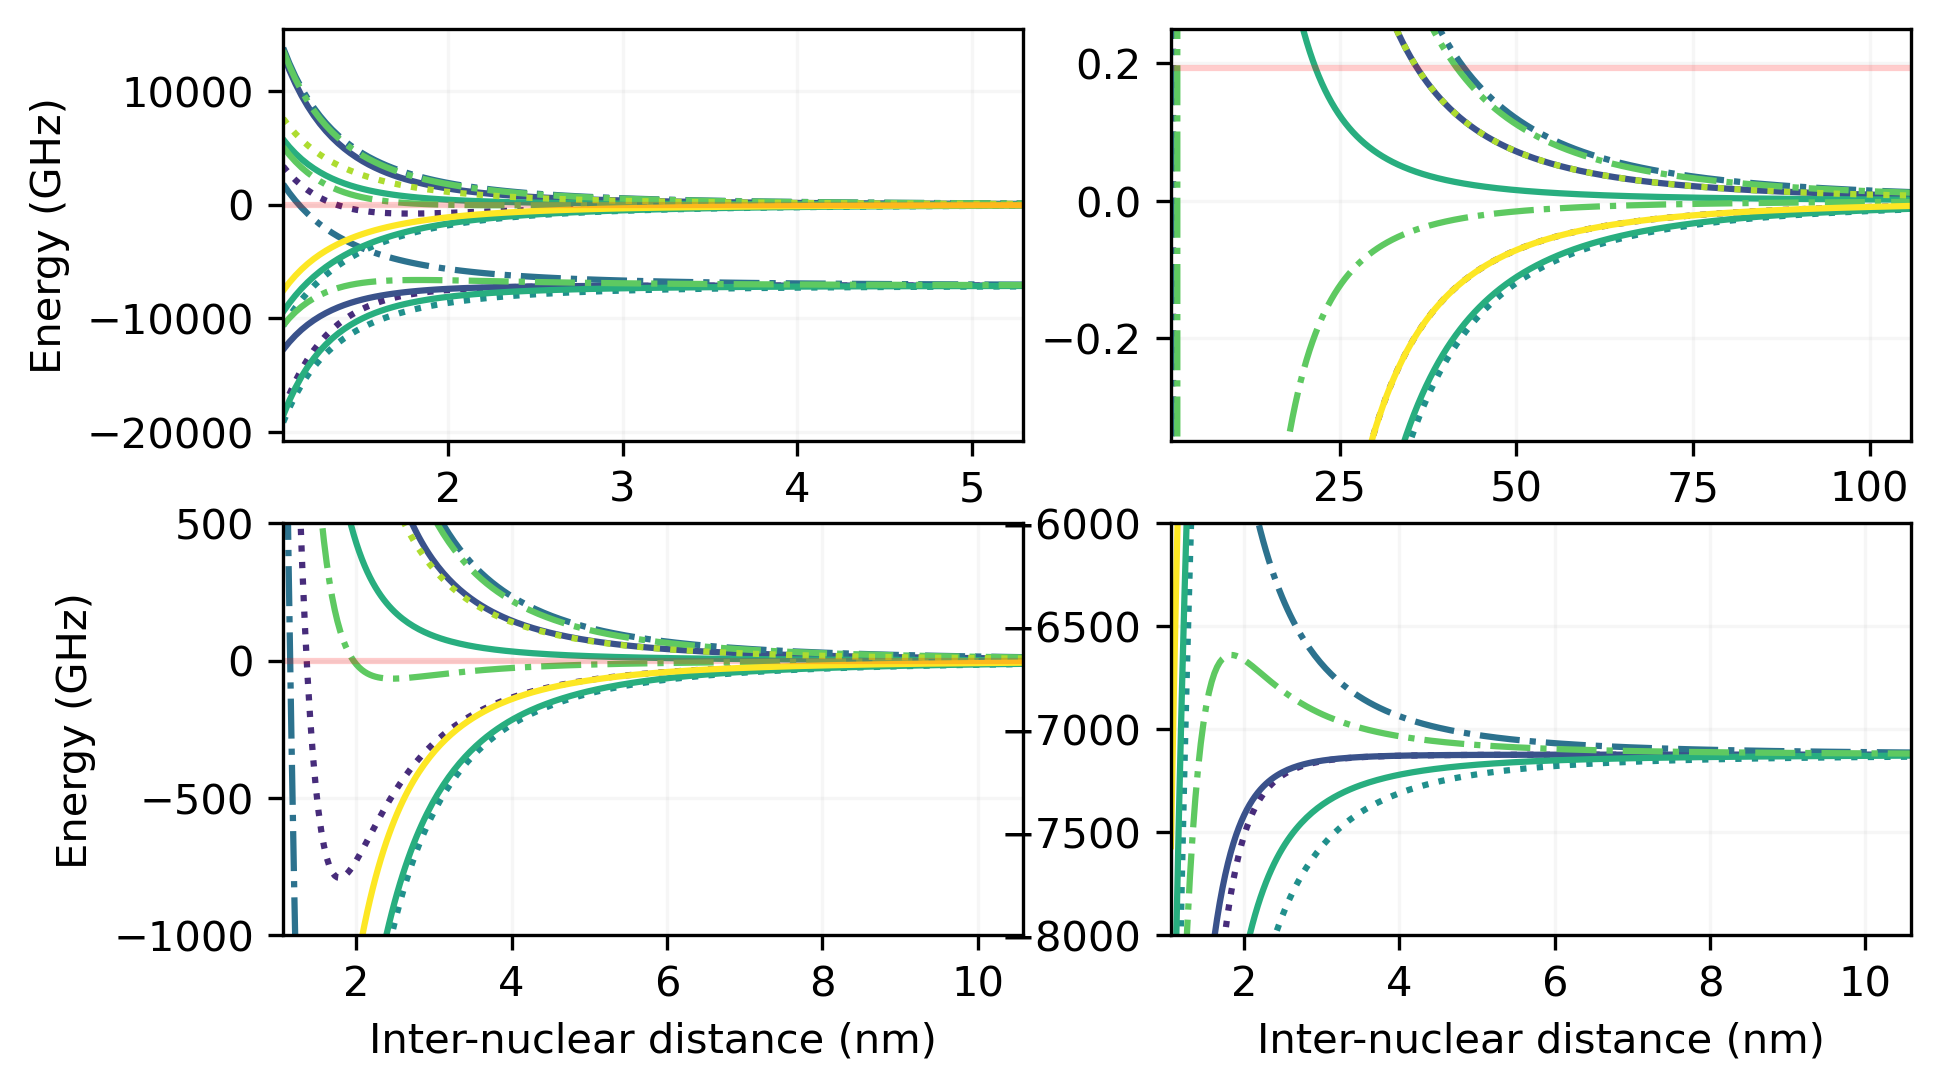

In [58]:
fig, axs = plt.subplots(2,2,figsize=(7,4))
Rvals = np.linspace( 20 * mc.a0, 2000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}
for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for ax in axs.flatten():
    if False:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=label if lineNum == 0 else None, color=c_, linestyle=linestyle)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    
    #ax.set_xlabel('Inter-nuclear distance (nm)')
    #ax.set_ylabel('Energy (GHz)')
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')

axs[1,0].set_xlabel('Inter-nuclear distance (nm)')
axs[1,1].set_xlabel('Inter-nuclear distance (nm)')
axs[0,0].set_ylabel('Energy (GHz)')
axs[1,0].set_ylabel('Energy (GHz)')
axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
#axs[0,0].legend(ncol=5,fontsize=8)
#axs[1,0].set_title('Zoom $5P_{3/2}$')
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-1000, 500)
#axs[0,1].set_title('Super-Zoom $5P_{3/2}""$')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[0,1].set_ylim(-0.35, 0.25)
#axs[1,1].set_title('Zoom $5P_{1/2}$')
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,1].set_ylim(-8000, -6000);
#plt.savefig('Movre-Pischler.png', dpi=200)www

### paper figure

In [113]:
mpl.rcParams['font.size'] = 8
mpl.rcParams['text.usetex']=True

<ipython-input-122-e2be8023315b>:56: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  fig.text(0.03, 0.5, "Energy (GHz)", rotation=90, verticalAlignment='center')
<ipython-input-122-e2be8023315b>:57: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  fig.text(0.5, 0.03, "Inter-Nuclear Distance (nm)", horizontalAlignment='center')


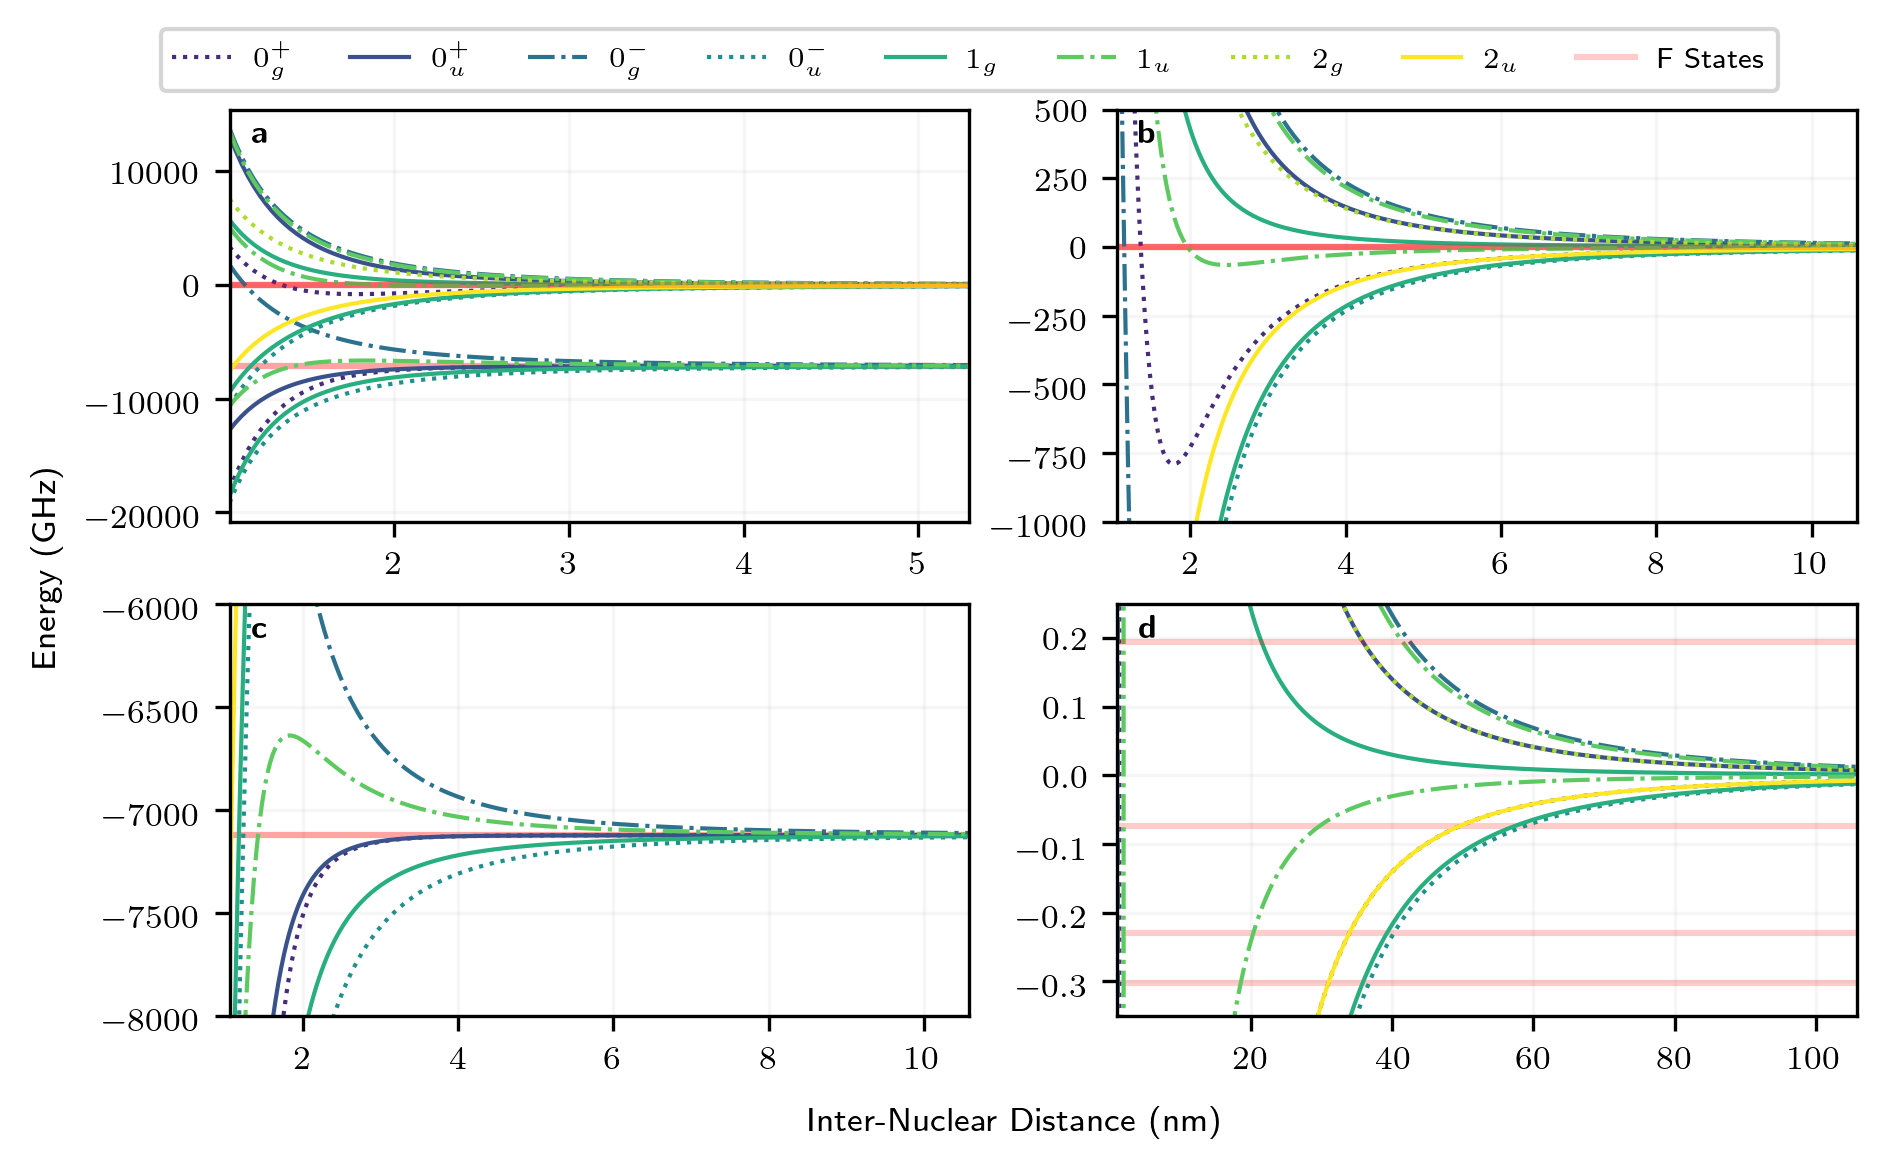

In [122]:
fig, axs = plt.subplots(2,2,figsize=(7,4))
Rvals = np.linspace( 20 * mc.a0, 2000 * mc.a0, 3000 )
linestyles=[':','-','-.',':','-','-.',':','-','-.',':','-','-.']
allBases = {**symmetrizedBases }
colors, _ = misc.getColors(len(allBases), cmStr='viridis')
data = {}

for basisNum, (label, basis) in enumerate(allBases.items()):
    #for matrixnum, (name, potentialMatrix, c_, boStates) in enumerate(zip(names, potentialList, colors, BohrOppenheimerStates)):
    for rv in Rvals:
        rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float) + H_fs_phi[label]
        #rMatrix = mol.get_H_BO(C_3_val, rv, basis).astype(float)
        #rMatrix = createBOMatrix(C_3_val, rv, *boStates).astype(float) + potentialMatrix * 2 * DeltaVal / 3
        if label not in data:
            data[label]=[]
        data[label].append(sorted(np.linalg.eigvals(rMatrix)))
        
for axnum, ax in enumerate(axs.flatten()):
    if True:
        ax.axhline(-0.0729113, alpha=0.2,color='r')
        ax.axhline(-0.2298518, alpha=0.2,color='r')
        ax.axhline(-0.30207388, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h+0.306246, alpha=0.2,color='r')
        ax.axhline(-DeltaVal* 1e-9 / mc.h-0.510410, alpha=0.2,color='r')
    
    for num, label in enumerate(data.keys()):
        mdata = data[label]
        linestyle = linestyles[num]
        c_ = colors[num]
        if len(label)==2:
            legLabel='$'+label[0]+'_'+label[1]+'$'
        if len(label)==3:
            legLabel='$'+label[0]+'^'+label[1]+'_'+label[2]+'$'
        if len(np.array(mdata).shape) == 2 or len(np.array(mdata).shape) == 3:
            for lineNum, lineData in enumerate(misc.transpose(mdata)):
                ax.plot(Rvals*1e9, np.array(lineData) * 1e-9 / mc.h, 
                        label=legLabel if lineNum == 0 else None, color=c_, linestyle=linestyle, lw=1)
        else:
            ax.plot(Rvals*1e9, np.array(mdata) * 1e-9 / mc.h, 
                    label=name, color=c_, linestyle=linestyle)
    ax.grid(alpha=0.1)
    ax.axhline(0.1937408, alpha=0.2,color='r', label='F States')
    ax.text(0.03, 0.92,r'\textbf{'+['a','b','c','d'][axnum]+r'}', transform=ax.transAxes)

axs[0,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/20)
axs[0,0].legend(ncol=9, fontsize=7, bbox_to_anchor=[0.5,0.87,1,0.5], loc='center')
axs[0,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[0,1].set_ylim(-1000, 500)
axs[1,1].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9)
axs[1,1].set_ylim(-0.35, 0.25)
axs[1,0].set_xlim(min(Rvals)*1e9,max(Rvals)*1e9/10)
axs[1,0].set_ylim(-8000, -6000);
#axs[0,0].axhline(-8000, linestyle=':',color='#AAAAAA')
#axs[0,0].axhline(-6000)

fig.text(0.03, 0.5, "Energy (GHz)", rotation=90, verticalAlignment='center')
fig.text(0.5, 0.03, "Inter-Nuclear Distance (nm)", horizontalAlignment='center')

plt.savefig('Fine_Structure_Only.png', dpi=200)